In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv


Gerekli kütüphaneler import edilir.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

In [22]:
df = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

**Kişisel Veri Analizi**

**Numeric EDA**

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


df.info() fonksiyonu ile veri setimiz ile ilgili genel bilgileri öğrendik. Veri setimizde 6362620 veri noktası bulunuyor ve veri setimizin boyutu 534 MB.

In [24]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


df.describe() fonksiyonu ile veri setimizi daha detaylı inceliiyoruz. Hangi değerden ne kadar bulunuyor, bu değerlerin max-min değerleri neler, standart sapması gibi verilere ulaşıyoruz. Mesela isFraud değerinin ortalaması(mean) 1.290820e-03. Bu şekilde diğer veriler ile ilgili sayısal bilgileri listeleyebiliriz.

In [25]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


df.head()f fonksiyonu ile verilerin neler olduğunu görüyüruz. Bazı veriler bizim istediğmiz formatta değil, bu verileri veri ön işleme adımı veri setimizi istediğimiz formata getiricez.

**Veri Ön İşleme**

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

İstediğmiz formata uymayan verilerden biri "type" verisi. String formatında bulunuyor ve kategorik şekilde. Kategorik olduğu için bu veriyi label encoding ön işlemden geçirerek istediğmiz formata dönüştürüyoruz.

In [27]:
df = df.drop(columns = 'nameOrig')
df = df.drop(columns = 'nameDest')

Aynı şekilde "nameOrig" ve "nameDest" verileride bizim için uygun formatta değiller. Bu yüzden bu verileri drop ediyoruz.

In [28]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


df.head() fonksiyonu ile verilerimizi tekrar kontrol ediyoruz ve artık modelimiz için uygun halde.

**Visual EDA**

<Axes: title={'center': 'Fraud Distribution Plot'}, xlabel='isFraud', ylabel='Density'>

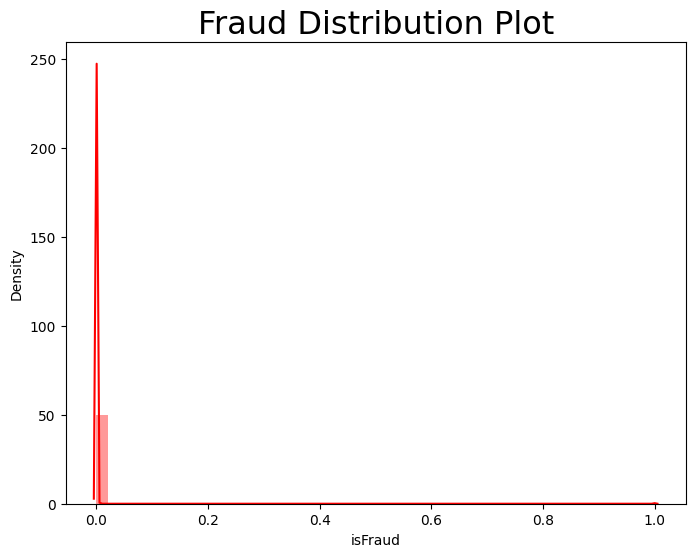

In [29]:
f0, ax = plt.subplots(figsize=(8, 6))
plt.title('Fraud Distribution Plot',fontsize=23)
sns.distplot(df['isFraud'], color='red')

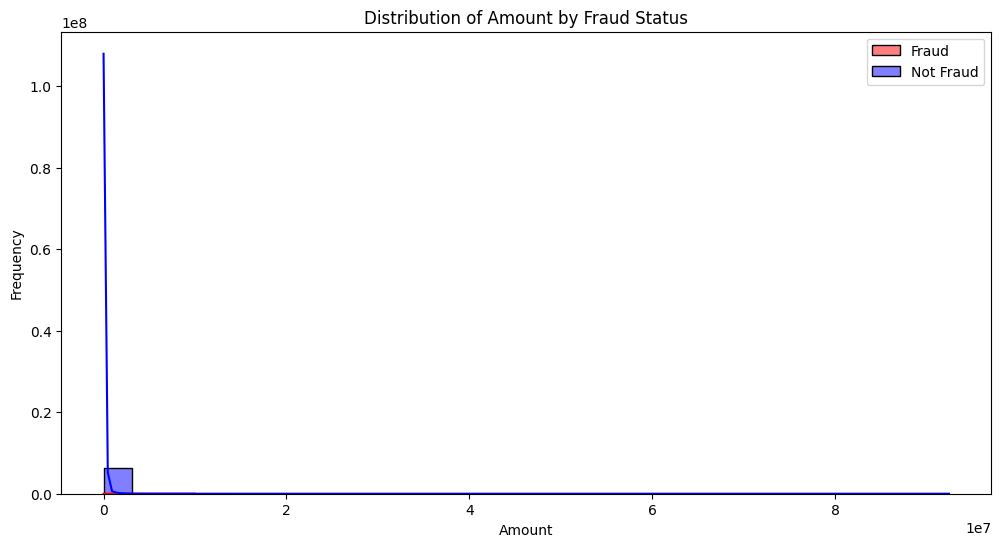

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['isFraud'] == 1]['amount'], color='red', label='Fraud', kde=True, bins=30)
sns.histplot(df[df['isFraud'] == 0]['amount'], color='blue', label='Not Fraud', kde=True, bins=30)
plt.title('Distribution of Amount by Fraud Status')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

İki farklı fraud ile ilgili dağılım grafiği çizdiriyoruz. not fraud değerinin ağırlıkta olduğunu gördük.

**Korelasyon Matrisi**

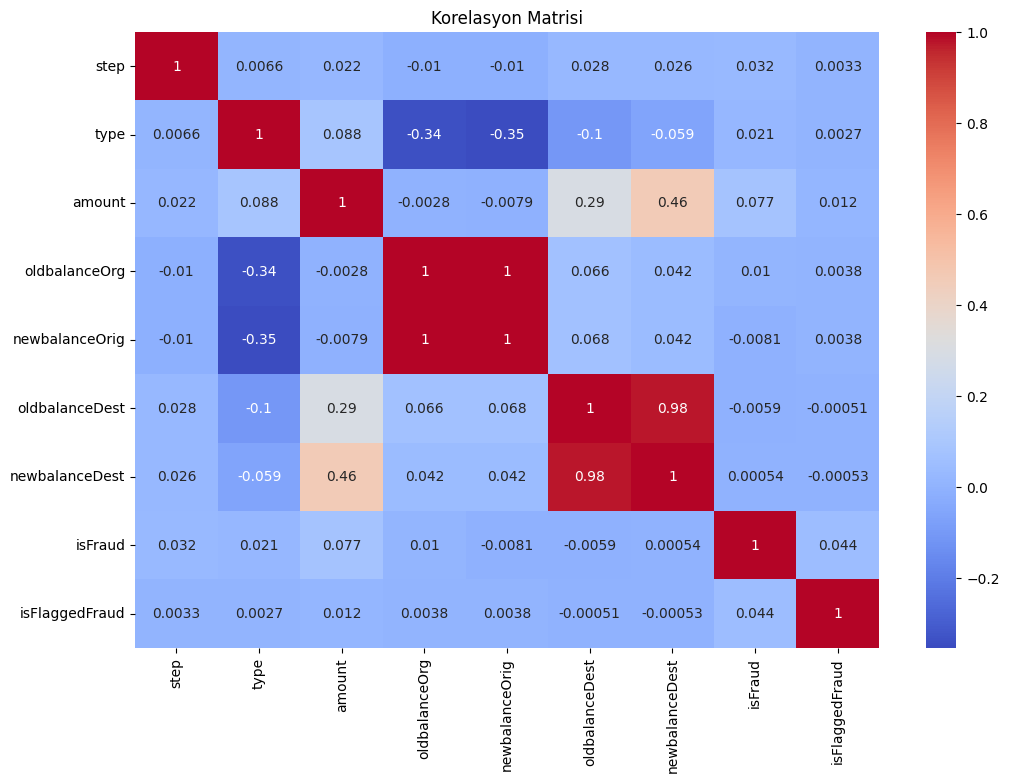

In [31]:
correlation_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

Text(0.5, 0.98, 'Negative Correlation Visualizations')

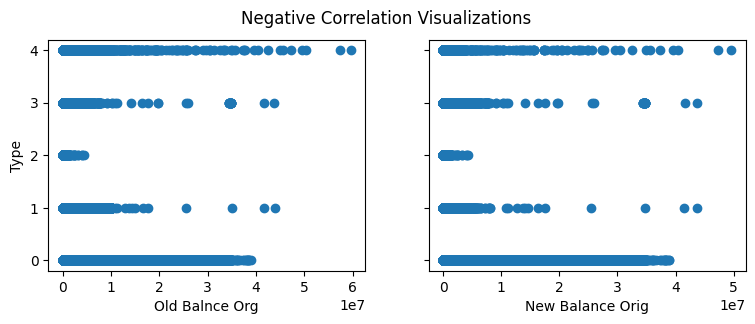

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].scatter(df["oldbalanceOrg"].values, df["type"].values)
axs[0].set_xlabel('Old Balnce Org')
axs[0].set_ylabel('Type')
axs[1].scatter(df["newbalanceOrig"].values, df["type"].values)
axs[1].set_xlabel('New Balance Orig')
fig.suptitle('Negative Correlation Visualizations')

Korelasyon matrisini incelediğimde type ile oldbalanceOrg ve newbalanceOrig verilerinin diğer verilere göre daha güçlü negatif korelasyona sahip olduklarını gördüm ve onları görselleştirmek istedim. Korelasyon değerleri birbirine yakın oldukları için benzer grafikler ortaya çıktı.

In [33]:
df = df.drop(columns = ['isFraud'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

Standar Scaler ile veriyi ölçeklendiriyoruz.

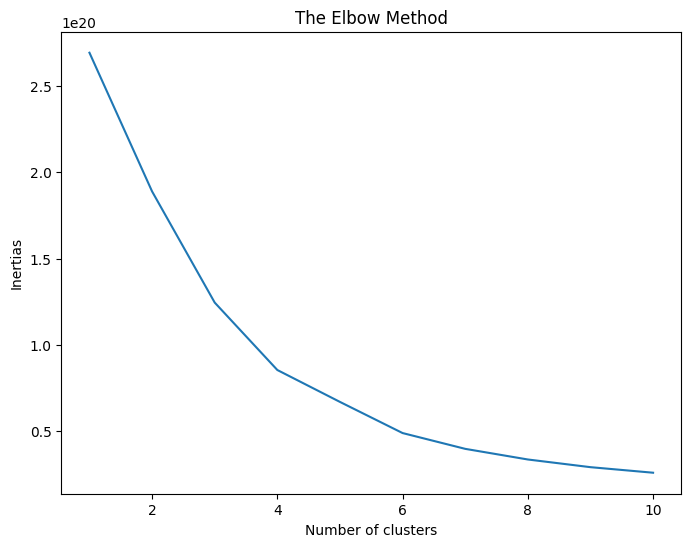

In [53]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)
f3, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,11),inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

NOT: Kaggle da elbow method grafiğini bastırmakta cpu nedeniyle sıkıntı yaşadım kod çıktıyı veriyor ama bu biraz zaman alabiliyor. Verilerimi de çıktıya göre belirledim.

Elbow yöntemi ile küme sayımızın değerini belirliyoruz. Elbow yöntemini kullanırken daha doğru bir sonuç elde etmek için ölçeklenmemiş veriyi kullanıyoruz. Küme sayısının 4 olabileceğini grafikten anlıyoruz çünkü orda bir kırılma var.

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42)  
training_points = X_scaled[:50000]
test_points = X_scaled[50000:]
kmeans.fit(training_points)
labels = kmeans.predict(test_points)
print(labels)

[3 3 3 ... 2 3 2]


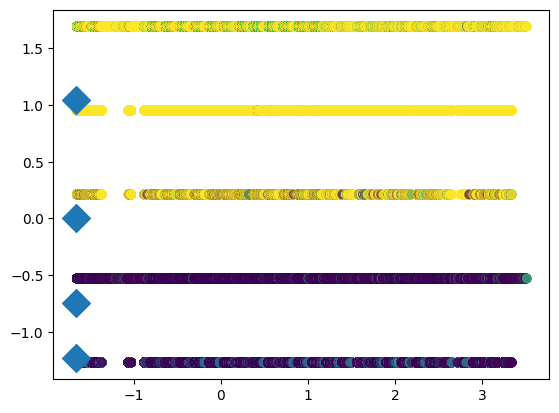

In [35]:
xs = test_points[:,0]
ys = test_points[:,1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = kmeans.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(centroids_x, centroids_y, marker='D',s=200)
plt.show()

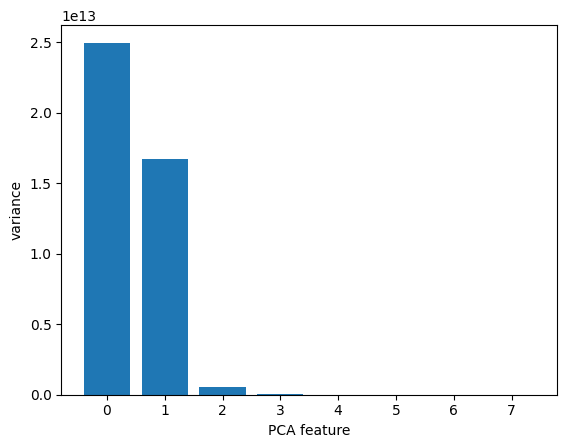

In [36]:
pca = PCA()
pca.fit(df)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

PCA ile veri setimizin içsel olarak 3 boyutlu olduğunu görüyoruz.

In [37]:
pca = PCA(n_components=3)
pca.fit(df)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.59007217 0.39557502 0.01289284]
0.9985400278442681


Bileşen sayımızı 3 olrak belirleyerek toplam varyansın %99.8 ini koruyabiliyoruz.

In [38]:
pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)

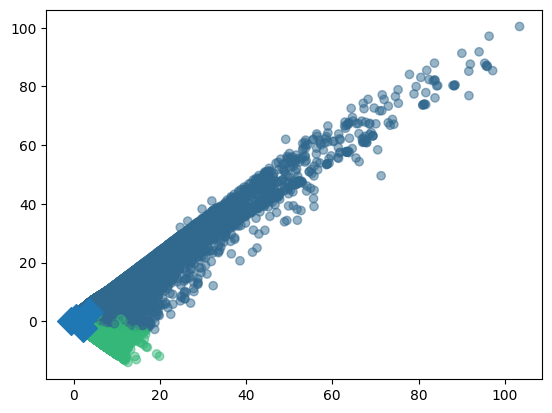

In [39]:
model = KMeans(n_clusters=4)
training_points = pca_features[:50000]
test_points = pca_features[50000:]
model.fit(training_points)
labels = model.predict(test_points)
xs = test_points[:,0]
ys = test_points[:,1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = model.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

plt.scatter(centroids_x, centroids_y, marker='D',s=200)
plt.show()

Küme merkezlerimizin değiştiğini görüyoruz.

**Hiyerarşik Kümeleme**

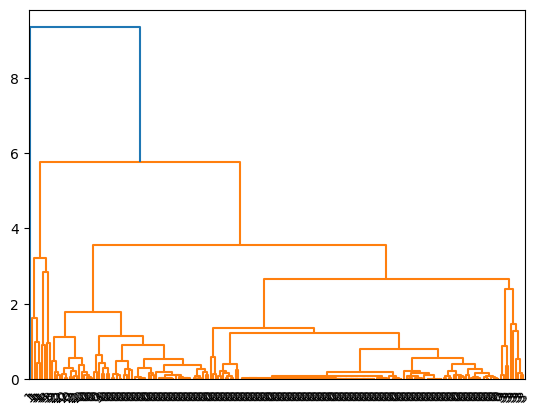

In [40]:
mergings = linkage(test_points[:200], method="complete")

dendrogram(mergings,
           labels=labels[:200],
           leaf_rotation=45,
           leaf_font_size=10,
)
plt.show()

**Silhouette Skoru**

Modeli değerlendirmek için kullanıcaz. Veri setimz çok büyük olduğu için rastgele 1000 örnek ile bu işlemi daha hızlı yapabiliriz.

In [52]:
from sklearn.metrics import silhouette_score

# Rastgele 1000 örnek seç
sample_indices = np.random.choice(test_points.shape[0], 1000, replace=False)
sample_points = test_points[sample_indices]
sample_labels = labels[sample_indices]

silhouette_avg = silhouette_score(sample_points, sample_labels)
print(f'Silhouette Score (Sampled): {silhouette_avg}')

Silhouette Score (Sampled): 0.454823083312295


Skor 0.45 çıktı ama kod bloğunu tekrar çalıştığımızda bu skor değişiyor. Ben birkaç kez çalıştırdığımda genellike 0.4 ün üzerinde bir skor çıktı. Bunun anlamı veri noktalrı genel olarak doğru kümelere aktarılmış.